# Import modules

In [91]:
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import chi2_contingency
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np
import seaborn
import pandas

# Data Import

In [92]:
heart_data = pandas.read_csv("data/heart.csv")

#### Data Cleaning

In [93]:
heart_data.loc[:,"ExerciseAngina"] = heart_data["ExerciseAngina"].apply(lambda x: 1 if x == "Y" else 0).astype("category")
heart_data.loc[:,"FastingBS"] = heart_data["FastingBS"].astype("category")
heart_data.loc[:,"HeartDisease"] = heart_data["HeartDisease"].astype(int)
heart_data = heart_data[heart_data["Cholesterol"] != 0]

# Exploratory Analysis

In [94]:
heart_data.head()
heart_data.info()
heart_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             746 non-null    int64   
 1   Sex             746 non-null    object  
 2   ChestPainType   746 non-null    object  
 3   RestingBP       746 non-null    int64   
 4   Cholesterol     746 non-null    int64   
 5   FastingBS       746 non-null    category
 6   RestingECG      746 non-null    object  
 7   MaxHR           746 non-null    int64   
 8   ExerciseAngina  746 non-null    category
 9   Oldpeak         746 non-null    float64 
 10  ST_Slope        746 non-null    object  
 11  HeartDisease    746 non-null    int32   
dtypes: category(2), float64(1), int32(1), int64(4), object(4)
memory usage: 62.9+ KB


,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,133.022788,244.635389,140.226542,0.901609,0.477212
std,9.505888,17.282750,59.153524,24.524107,1.072861,0.499816
min,28.000000,92.000000,85.000000,69.000000,-0.100000,0.000000
25%,46.000000,120.000000,207.250000,122.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,140.000000,0.500000,0.000000
75%,59.000000,140.000000,275.000000,160.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,1.000000


We can see from the above that each column has the appropriate data type, and there are no empty values. So the data is sufficiently cleaned for our purposes

However, heart_data.describe() does not give us a detailed enough picture of the distribution of each column, so let's continue exploring

## Analysis of Numerical Variables

### Checking for data imbalance

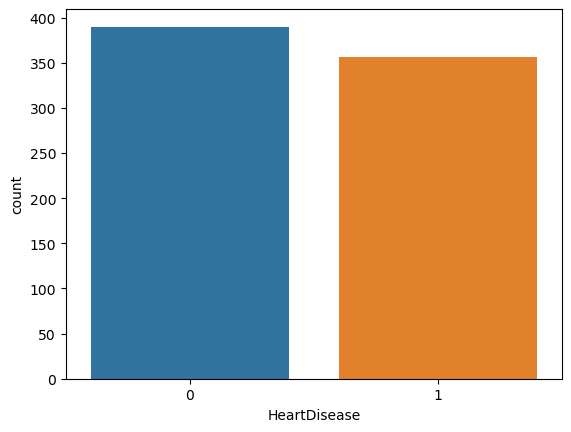

In [95]:
seaborn.countplot(data=heart_data, x="HeartDisease")
plt.show()

Based on this, we can see that our dataset is fairly balanced

### Basic Univariate Analysis

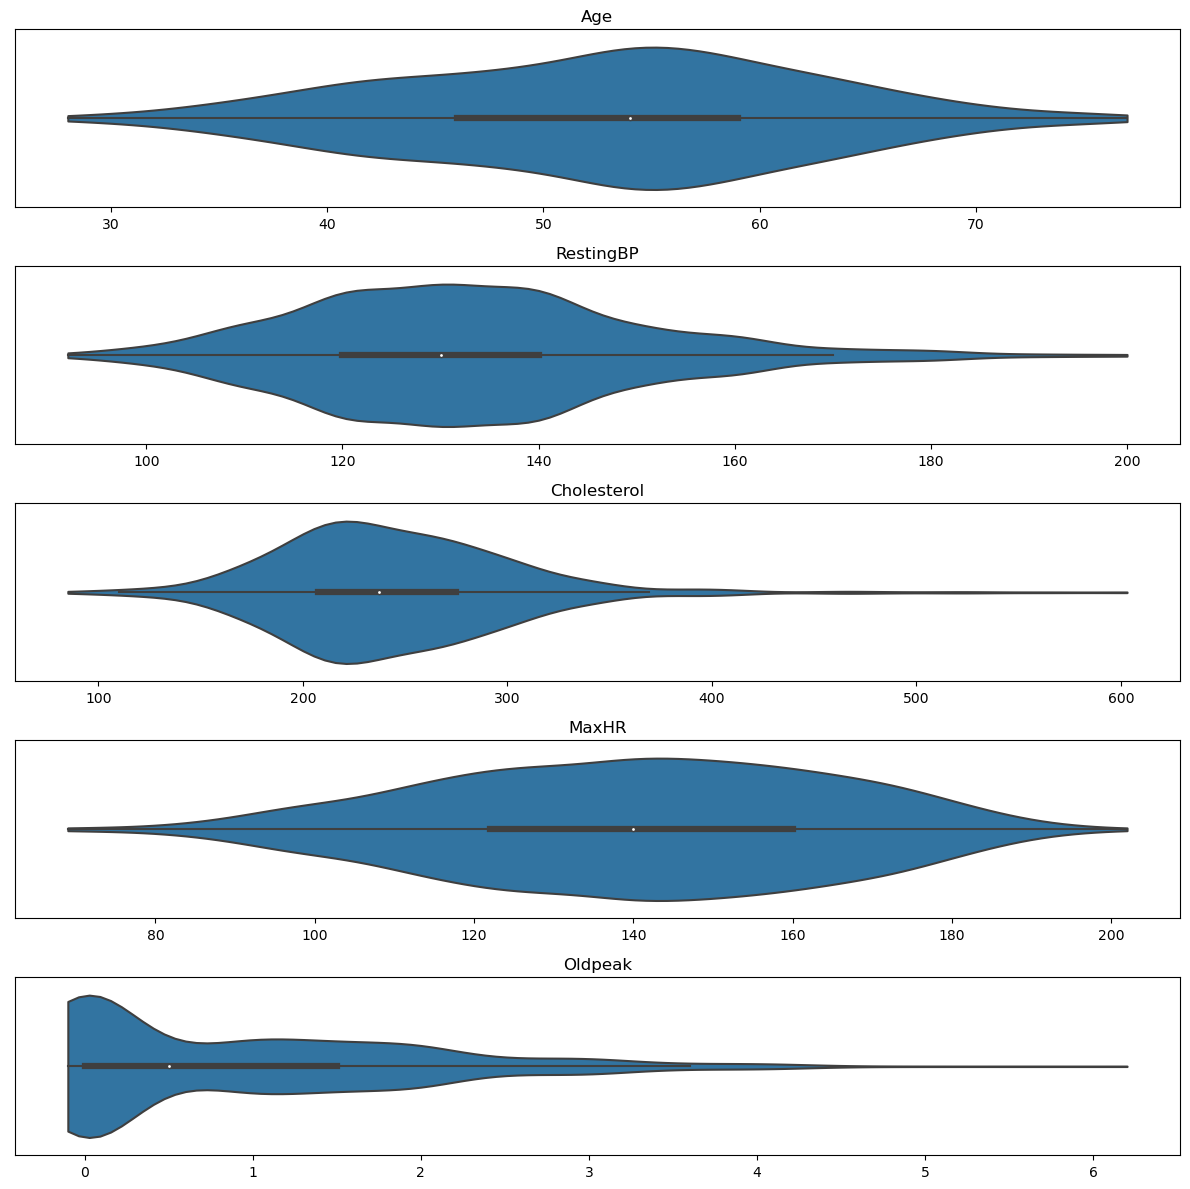

In [96]:
variables = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

fig, ax = plt.subplots(5, 1, figsize=(12, 12))

for index, variable in enumerate(variables):
    seaborn.violinplot(data=heart_data[variable], ax=ax[index], orient="h", cut=0)
    ax[index].set_title(variable)
    ax[index].set_yticklabels([])
    ax[index].set_yticks([])

fig.tight_layout()


We can now see how each of the variables are distributed. Let's see if the presence of heart disease shows us any kind of separation

### Exploring Relationship with Response Variable

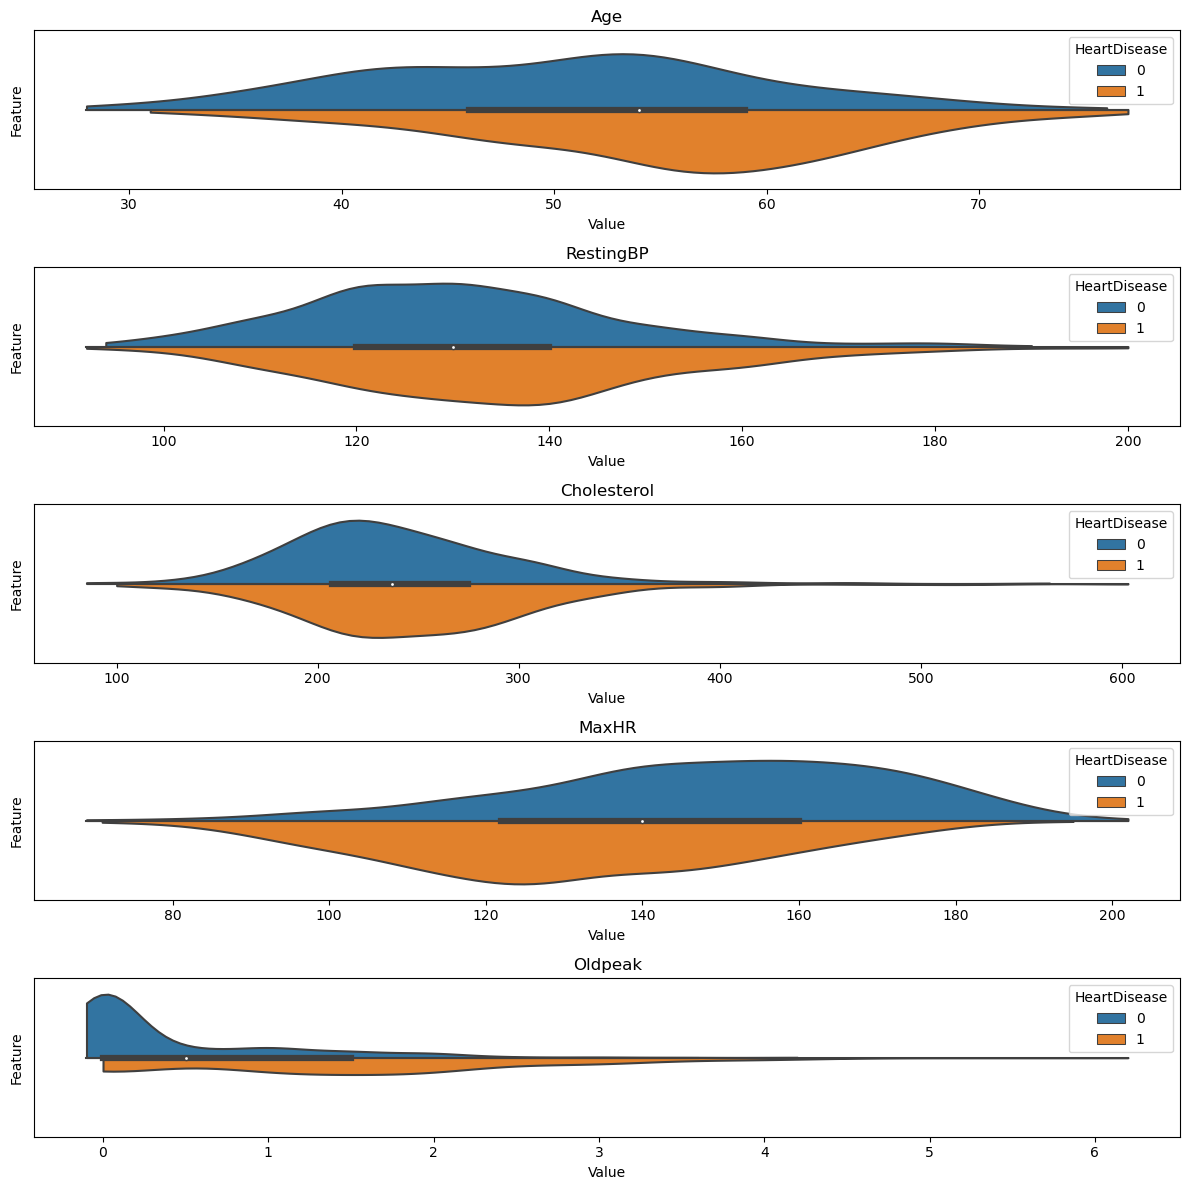

In [97]:
fig, ax = plt.subplots(5, 1, figsize=(12, 12))

for index, variable in enumerate(variables):
    plot_data = heart_data.loc[:,[variable, "HeartDisease"]].melt(id_vars="HeartDisease", var_name="Feature", value_name="Value")
    seaborn.violinplot(data=plot_data, y="Feature", x="Value", hue="HeartDisease", split=True, orient="h", cut=0, ax=ax[index])
    ax[index].set_title(variable)
    ax[index].set_yticklabels([])
    ax[index].set_yticks([])

fig.tight_layout()


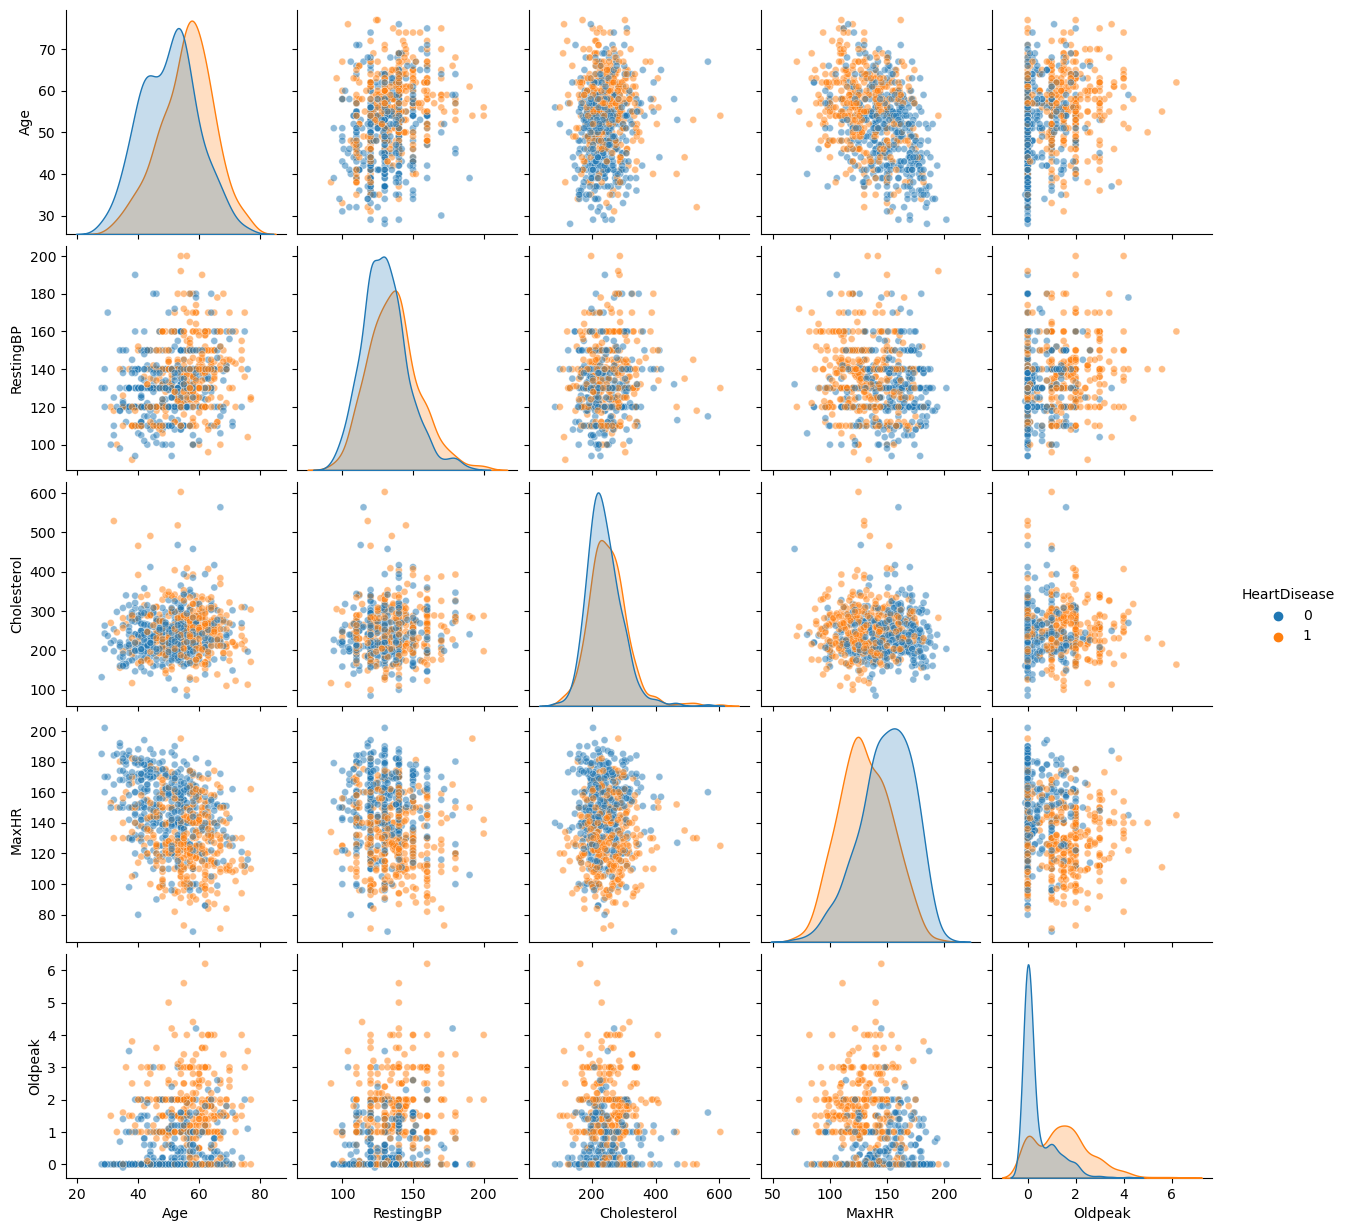

In [98]:
seaborn.pairplot(heart_data, hue="HeartDisease", vars=variables, plot_kws={"s": 25, "alpha": 0.5})
plt.show()

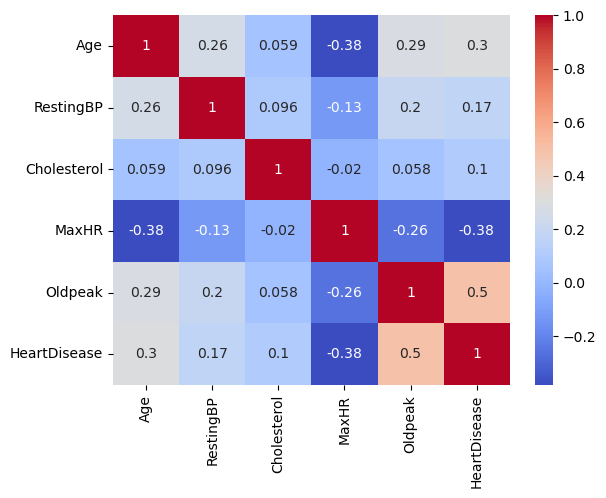

In [99]:
correlation = heart_data.corr()
seaborn.heatmap(correlation, annot=True, cmap="coolwarm")
plt.show()

From the above plots, we can see observe that Oldpeak, Age, and MaxHR seems to have some correlation to HeartDisease

# Analysis of Categorical Variables

### Basic Univariate Analysis

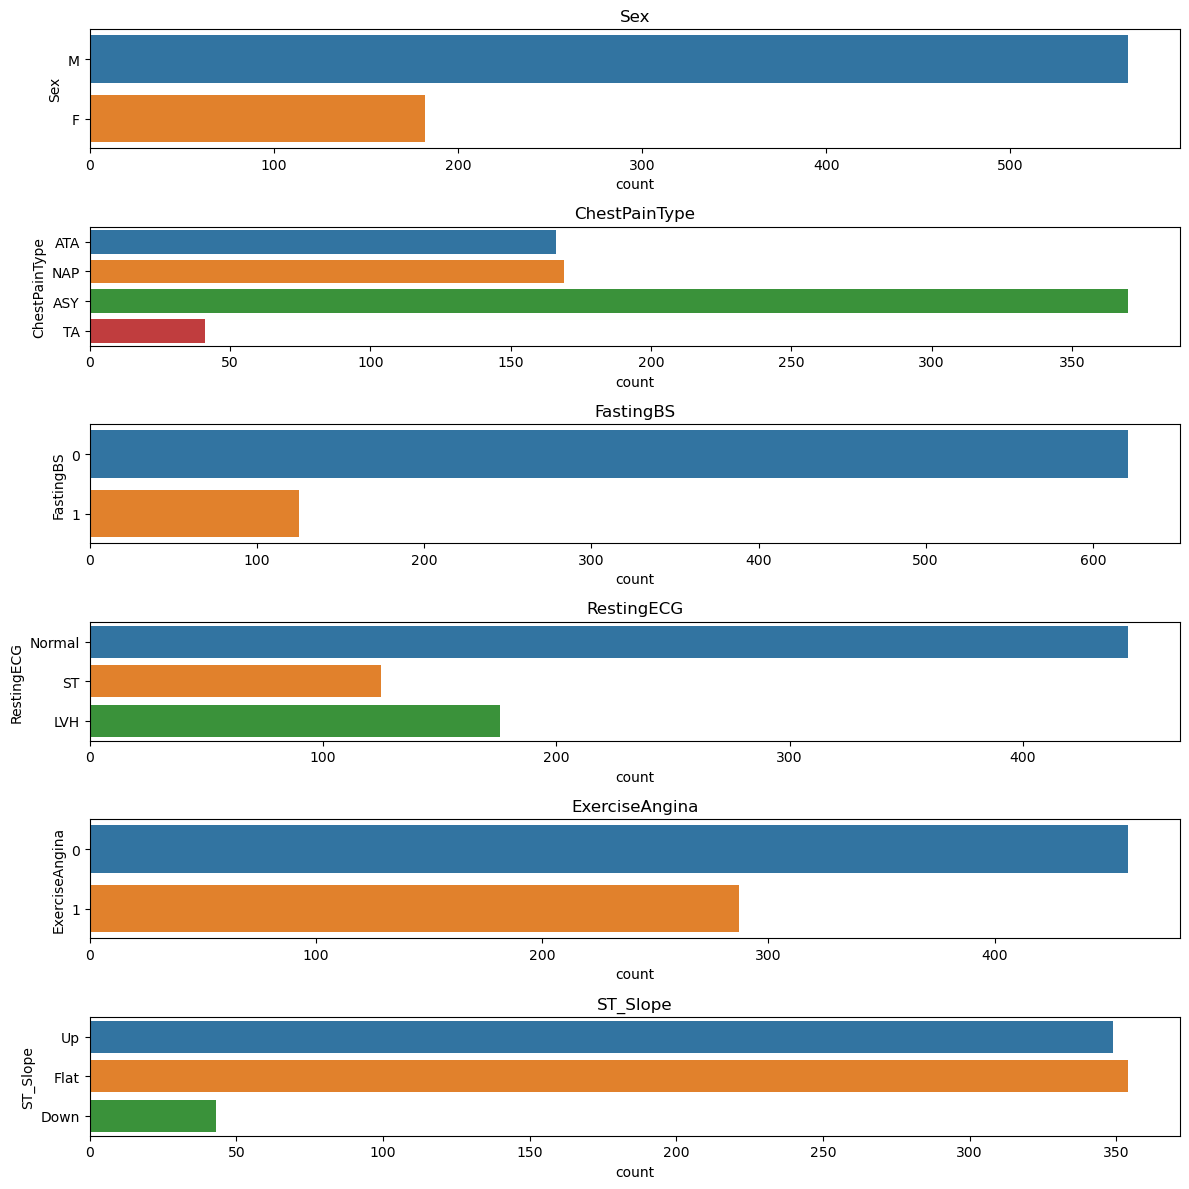

In [100]:
variables = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]

fig, ax = plt.subplots(6, 1, figsize=(12, 12))

for index, variable in enumerate(variables):
    seaborn.countplot(data=heart_data, y=variable, ax=ax[index])
    ax[index].set_title(variable)

fig.tight_layout()

The above gives us a fairly clear picture of the distribution of categorical variables, again, let's see if seperating the data by HeartDisease shows us any patterns

### Exploring Relationship with Response Variable

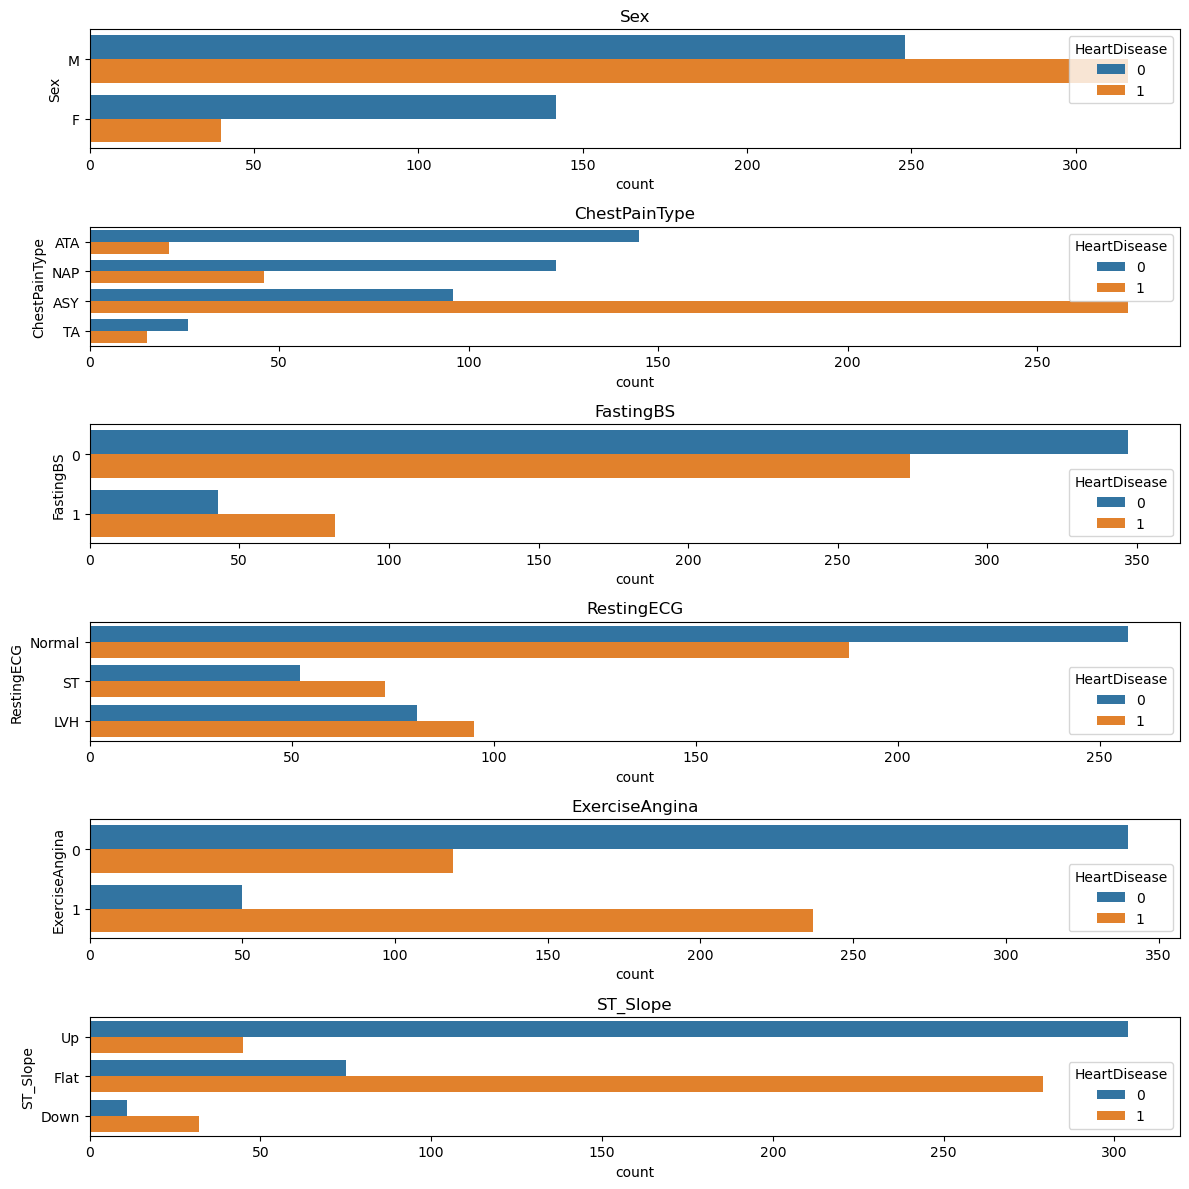

In [101]:
fig, ax = plt.subplots(6, 1, figsize=(12, 12))

for index, variable in enumerate(variables):
    seaborn.countplot(data=heart_data, y=variable, hue="HeartDisease", ax=ax[index])
    ax[index].set_title(variable)

fig.tight_layout()

In [102]:
p_values = pandas.DataFrame([])

for variable in variables:
    cont_table = pandas.crosstab(heart_data[variable], heart_data['HeartDisease'])
    stat, pval, _, _ = chi2_contingency(cont_table)
    p_values = pandas.concat([p_values, pandas.DataFrame({"p-value": pval}, index=[variable])])

p_values.sort_values("p-value", inplace=True)
p_values

,p-value
ST_Slope,5.013555e-70
ExerciseAngina,7.690036e-51
ChestPainType,2.199658e-46
Sex,2.546612e-15
FastingBS,1.801490e-05
RestingECG,9.979468e-04


From the above plots, it is readily apparent that ChestPainType, ExerciseAngina, ST_Slope are quite strongly correlated to HeartDisease.

Sex, FastingBS and RestingECG also seem to be correlated

# Machine Learning

### Creating test split

In [103]:
x = heart_data.loc[:, ["ChestPainType", "ExerciseAngina", "ST_Slope", "Oldpeak", "Age", "MaxHR"]]
x = pandas.get_dummies(x, columns=["ChestPainType", "ST_Slope"])

y = heart_data["HeartDisease"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Searching for optimal parameters

In [104]:
# THIS WILL RUN FOR AN HOUR
if (False):
    parameters = {'n_estimators': np.arange(100,1001,100), 'max_depth': np.arange(2, 11), "class_weight": [{0:1, 1:x} for x in np.arange(1, 4, 0.1)]}

    grid_search = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'recall')
    grid_search.fit(x_train, y_train.ravel())

    print("Random Forest")
    print(f"Best Parameters: {grid_search.best_estimator_}")
    print(f"Best Score: {np.abs(grid_search.best_score_)}")

    parameters = {'max_iter': np.arange(1000,100001,1000), "class_weight": [{0:1, 1:x} for x in np.arange(1, 4, 0.1)]}

    grid_search = GridSearchCV(SVC(), parameters, scoring = 'recall')
    grid_search.fit(x_train, y_train.ravel())

    print("Support Vector Classifier")
    print(f"Best Parameters: {grid_search.best_estimator_}")
    print(f"Best Score: {np.abs(grid_search.best_score_)}")

    parameters = {'max_iter': np.arange(1000,100001,1000), "class_weight": [{0:1, 1:x} for x in np.arange(1, 4, 0.1)]}

    grid_search = GridSearchCV(LogisticRegression(), parameters, scoring = 'recall')
    grid_search.fit(x_train, y_train.ravel())

    print("Logistics Regression")
    print(f"Best Parameters: {grid_search.best_estimator_}")
    print(f"Best Score: {np.abs(grid_search.best_score_)}")

As the cost of incorrectly diagnosing a patient as free of heart disease (false negative) is greater than the cost of incorrectly diagnosing a patient as having heart disease (false positive), we search for how much to increase the weight of the "1" label to decrease this false positive rate.

## Random Forest Classifier

### Training the model

Train Data
Accuracy  :	 0.8053691275167785

TPR Train :	 0.9494584837545126 <-- Recall
TNR Train :	 0.6802507836990596

FPR Train :	 0.31974921630094044
FNR Train :	 0.05054151624548736


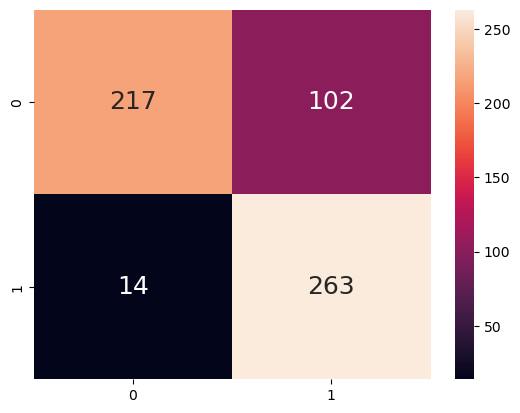

In [105]:
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=2, n_estimators=200, class_weight={0: 1, 1: 3.9}))
pipeline.fit(x_train, y_train)
y_train_prediction = pipeline.predict(x_train)

print("Train Data")
print("Accuracy  :\t", pipeline.score(x_train, y_train))
print()

matrix = confusion_matrix(y_train, y_train_prediction)
true_positives = matrix[1][1] # True Positives : Good (1) predicted Good (1)
false_positives = matrix[0][1] # False Positives : Bad (0) predicted Good (1)
true_negatives = matrix[0][0] # True Negatives : Bad (0) predicted Bad (0)
false_negatives = matrix[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (true_positives/(true_positives + false_negatives)), "<-- Recall")
print("TNR Train :\t", (true_negatives/(true_negatives + false_positives)))
print()

print("FPR Train :\t", (false_positives/(true_negatives + false_positives)))
print("FNR Train :\t", (false_negatives/(true_positives + false_negatives)))

plt.clf()
seaborn.heatmap(confusion_matrix(y_train, y_train_prediction), annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

### Testing the model

Test Data
Accuracy  :	 0.8733333333333333

TPR Train :	 0.9494584837545126 <-- Recall
TNR Train :	 0.6802507836990596

FPR Train :	 0.31974921630094044
FNR Train :	 0.05054151624548736


<AxesSubplot:>

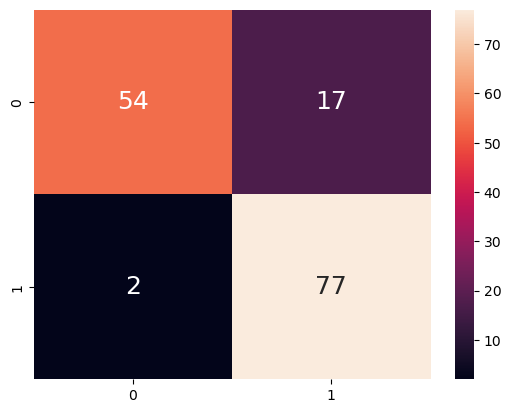

In [106]:
y_test_prediction = pipeline.predict(x_test)

print("Test Data")
print("Accuracy  :\t", pipeline.score(x_test, y_test))
print()

matrix = confusion_matrix(y_train, y_train_prediction)
true_positives = matrix[1][1] # True Positives : Good (1) predicted Good (1)
false_positives = matrix[0][1] # False Positives : Bad (0) predicted Good (1)
true_negatives = matrix[0][0] # True Negatives : Bad (0) predicted Bad (0)
false_negatives = matrix[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (true_positives/(true_positives + false_negatives)), "<-- Recall")
print("TNR Train :\t", (true_negatives/(true_negatives + false_positives)))
print()

print("FPR Train :\t", (false_positives/(true_negatives + false_positives)))
print("FNR Train :\t", (false_negatives/(true_positives + false_negatives)))

seaborn.heatmap(confusion_matrix(y_test, y_test_prediction), annot = True, fmt=".0f", annot_kws={"size": 18})

## Support Vector Classifier

### Training the model

Train Data
Accuracy  :	 0.8439597315436241

TPR Train :	 0.9566787003610109 <-- Recall
TNR Train :	 0.7460815047021944

FPR Train :	 0.25391849529780564
FNR Train :	 0.04332129963898917


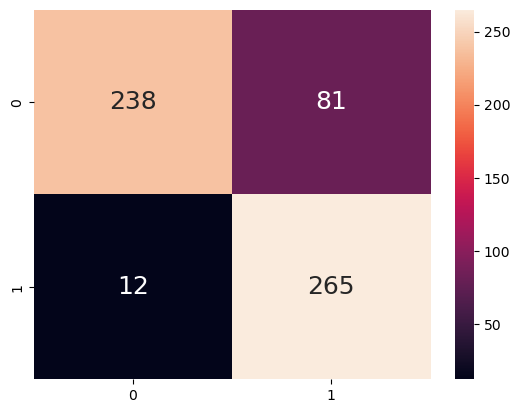

In [107]:
pipeline = make_pipeline(StandardScaler(), SVC(gamma='auto', class_weight={0: 1, 1: 3.4}))
pipeline.fit(x_train, y_train)
y_train_prediction = pipeline.predict(x_train)

print("Train Data")
print("Accuracy  :\t", pipeline.score(x_train, y_train))
print()

matrix = confusion_matrix(y_train, y_train_prediction)
true_positives = matrix[1][1] # True Positives : Good (1) predicted Good (1)
false_positives = matrix[0][1] # False Positives : Bad (0) predicted Good (1)
true_negatives = matrix[0][0] # True Negatives : Bad (0) predicted Bad (0)
false_negatives = matrix[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (true_positives/(true_positives + false_negatives)), "<-- Recall")
print("TNR Train :\t", (true_negatives/(true_negatives + false_positives)))
print()

print("FPR Train :\t", (false_positives/(true_negatives + false_positives)))
print("FNR Train :\t", (false_negatives/(true_positives + false_negatives)))

seaborn.heatmap(confusion_matrix(y_train, y_train_prediction), annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

### Testing the model

Test Data
Accuracy  :	 0.8933333333333333

TPR Train :	 0.9566787003610109 <-- Recall
TNR Train :	 0.7460815047021944

FPR Train :	 0.25391849529780564
FNR Train :	 0.04332129963898917


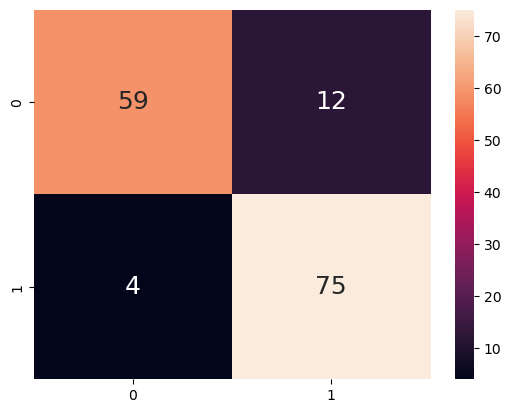

In [108]:
y_test_prediction = pipeline.predict(x_test)

print("Test Data")
print("Accuracy  :\t", pipeline.score(x_test, y_test))
print()

matrix = confusion_matrix(y_train, y_train_prediction)
true_positives = matrix[1][1] # True Positives : Good (1) predicted Good (1)
false_positives = matrix[0][1] # False Positives : Bad (0) predicted Good (1)
true_negatives = matrix[0][0] # True Negatives : Bad (0) predicted Bad (0)
false_negatives = matrix[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (true_positives/(true_positives + false_negatives)), "<-- Recall")
print("TNR Train :\t", (true_negatives/(true_negatives + false_positives)))
print()

print("FPR Train :\t", (false_positives/(true_negatives + false_positives)))
print("FNR Train :\t", (false_negatives/(true_positives + false_negatives)))

seaborn.heatmap(confusion_matrix(y_test, y_test_prediction), annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

## Logistics Regression

### Training the model

Train Data
Accuracy  :	 0.8204697986577181

TPR Train :	 0.9422382671480144 <-- Recall
TNR Train :	 0.7147335423197492

FPR Train :	 0.2852664576802508
FNR Train :	 0.05776173285198556


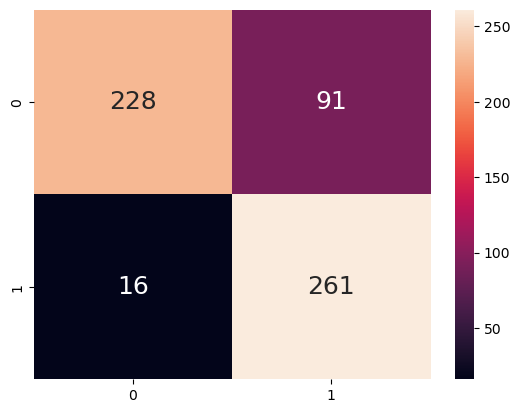

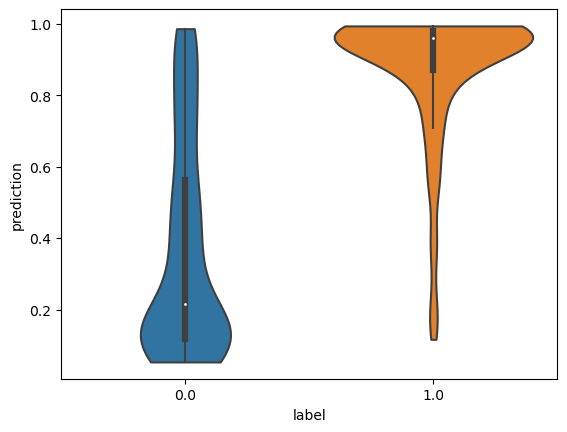

In [109]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, class_weight={0: 1, 1: 3.4}))
pipeline.fit(x_train, y_train)

y_train_prediction = pipeline.predict(x_train)
y_train_confidence = pipeline.predict_proba(x_train)

print("Train Data")
print("Accuracy  :\t", pipeline.score(x_train, y_train))
print()

matrix = confusion_matrix(y_train, y_train_prediction)
true_positives = matrix[1][1] # True Positives : Good (1) predicted Good (1)
false_positives = matrix[0][1] # False Positives : Bad (0) predicted Good (1)
true_negatives = matrix[0][0] # True Negatives : Bad (0) predicted Bad (0)
false_negatives = matrix[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (true_positives/(true_positives + false_negatives)), "<-- Recall")
print("TNR Train :\t", (true_negatives/(true_negatives + false_positives)))
print()

print("FPR Train :\t", (false_positives/(true_negatives + false_positives)))
print("FNR Train :\t", (false_negatives/(true_positives + false_negatives)))

seaborn.heatmap(confusion_matrix(y_train, y_train_prediction), annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

seaborn.violinplot(data=pandas.DataFrame([y_train_confidence[:,1], y_train], index=["prediction", "label"]).transpose(), x="label", y="prediction", cut=0)
plt.show()

### Testing the model

Test Data
Accuracy  :	 0.9

TPR Train :	 0.9422382671480144 <-- Recall
TNR Train :	 0.7147335423197492

FPR Train :	 0.2852664576802508
FNR Train :	 0.05776173285198556


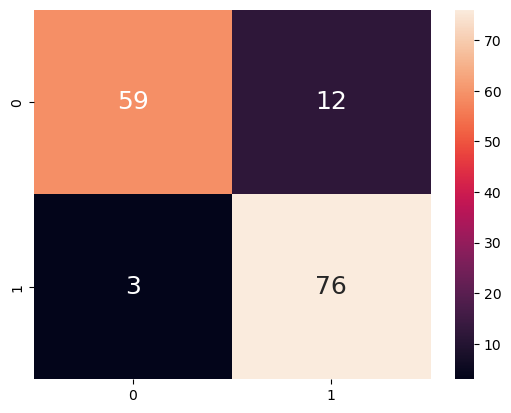

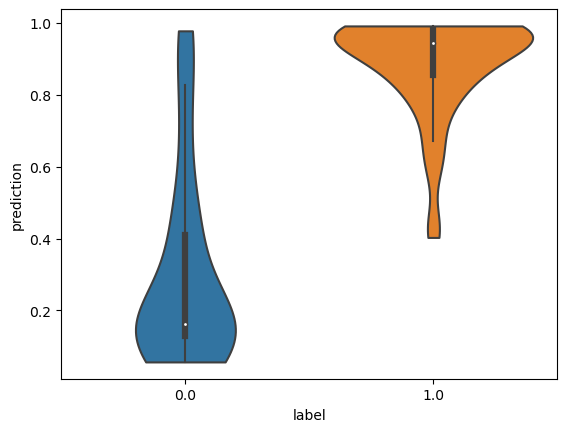

In [110]:
y_test_pred = pipeline.predict(x_test)
y_test_confidence = pipeline.predict_proba(x_test)

print("Test Data")
print("Accuracy  :\t", pipeline.score(x_test, y_test))
print()

matrix = confusion_matrix(y_train, y_train_prediction)
true_positives = matrix[1][1] # True Positives : Good (1) predicted Good (1)
false_positives = matrix[0][1] # False Positives : Bad (0) predicted Good (1)
true_negatives = matrix[0][0] # True Negatives : Bad (0) predicted Bad (0)
false_negatives = matrix[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (true_positives/(true_positives + false_negatives)), "<-- Recall")
print("TNR Train :\t", (true_negatives/(true_negatives + false_positives)))
print()

print("FPR Train :\t", (false_positives/(true_negatives + false_positives)))
print("FNR Train :\t", (false_negatives/(true_positives + false_negatives)))

seaborn.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt=".0f", annot_kws={"size": 18})
plt.show()

seaborn.violinplot(data=pandas.DataFrame([y_test_confidence[:,1], y_test], index=["prediction", "label"]).transpose(), x="label", y="prediction", cut=0)
plt.show()

#### Analysing False Negative Cases

In [120]:
data_with_confidence = pandas.concat([x_test, pandas.Series(y_test_confidence[:,1], name="confidence")], axis=1)

false_negative_indices = np.where((y_test_prediction == 0) & (y_test == 1))[0]
negative_view = data_with_confidence.iloc[false_negative_indices.ravel().tolist(),:].sort_values(by="confidence", ascending=False)
display(negative_view.drop(22))

,ExerciseAngina,Oldpeak,Age,MaxHR,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,confidence
63,0,0.8,46,144,1,0,0,0,0,0,1,0.443675
47,0,2.5,67,125,0,0,0,1,0,0,1,0.428160
49,0,0.0,44,177,1,0,0,0,0,0,1,0.403030


#### Analysing False Positive Cases

In [121]:
false_positive_indices = np.where((y_test_prediction == 1) & (y_test == 0))[0]
positive_view = data_with_confidence.iloc[false_positive_indices.ravel().tolist(),:].sort_values(by="confidence", ascending=False)
display(positive_view.head())
display(positive_view.drop([117,85]).tail())

,ExerciseAngina,Oldpeak,Age,MaxHR,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,confidence
139,1,0.2,64,105,1,0,0,0,0,1,0,0.977085
57,1,1.5,52,140,1,0,0,0,0,1,0,0.976814
20,1,1.0,48,130,1,0,0,0,0,1,0,0.966542
141,1,0.2,45,152,1,0,0,0,0,1,0,0.956816
69,0,1.0,58,122,1,0,0,0,0,1,0,0.933973


,ExerciseAngina,Oldpeak,Age,MaxHR,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,confidence
28,0,1.5,68,115,0,0,1,0,0,1,0,0.827960
16,1,0.0,64,154,1,0,0,0,0,0,1,0.826484
119,1,1.0,39,160,0,1,0,0,0,1,0,0.799170
27,0,0.1,52,169,0,0,1,0,0,1,0,0.664560
88,0,0.6,45,175,0,1,0,0,0,1,0,0.616803
